# Set up

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-04-06 09:50:34.564574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Performing PCA with an Undercomplete Linear Autoencoder

In [2]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

2024-04-06 09:50:36.950352: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Now, we generate the same 3D dataset we used in chapter 8.

In [3]:
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.randn(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 + np.random.randn(m, 3)  # add more noises
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=0)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


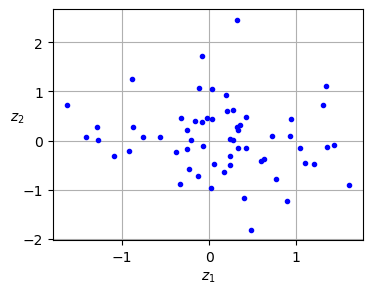

In [5]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.grid()

## Implementing a Stacked Autoencoder Using Keras

We will use the Fashion MNIST dataset for this problem. 

In [7]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [8]:
encoder = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(30, activation="relu"),
    ]
)

decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(28 * 28),
        tf.keras.layers.Reshape([28, 28]),
    ]
)

stacked_ae = tf.keras.Sequential([encoder, decoder])
stacked_ae.compile(loss="mse", optimizer="nadam")
stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.0240 - val_loss: 0.0185
Epoch 2/20
1719/1719 [==============================] - 22s 13ms/step - loss: 0.0173 - val_loss: 0.0166
Epoch 3/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 4/20
1719/1719 [==============================] - 25s 15ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 5/20
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 6/20
1719/1719 [==============================] - 16s 10ms/step - loss: 0.0145 - val_loss: 0.0146
Epoch 7/20
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 8/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0141 - val_loss: 0.0148
Epoch 9/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 10/20
1719/1719 [==============================] - 12s 7ms/ste

## Visualizing the Reconstructions

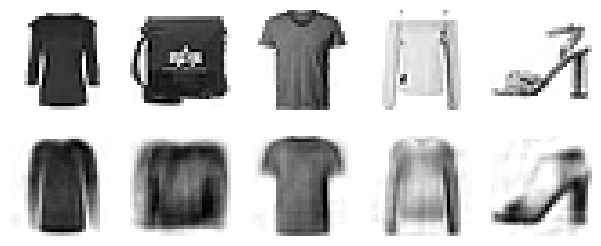

In [29]:
def plot_reconstruction(model: tf.keras.Sequential, images=X_valid, n_images=5):
    predict_images = model.predict(images[:n_images], verbose=0)
    clipped_predict_images = np.clip(predict_images, 0, 1)
    plt.figure(figsize=(n_images * 1.5, 3))
    for idx in range(n_images):
        plt.subplot(2, n_images, idx + 1)
        plt.imshow(images[idx], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + idx)
        plt.imshow(clipped_predict_images[idx], cmap="binary")
        plt.axis("off")
    plt.show()


plot_reconstruction(stacked_ae)